In [1]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

In [3]:
#%% 
#Helpers and functions
from helpers import select_top_n, prepare_data, plotbar_multi, df_explode, plt_wraplabel, df_row_normalize 


import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import textwrap
 

# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

sns.set_theme(style="ticks", palette=palette)

# Define the palette as a list to specify exact values
cmap = sns.color_palette("rocket_r", as_cmap=True)
palette = sns.color_palette("rocket_r")

sns.set_theme(style="ticks", palette=palette)


%matplotlib inline


# StackOverflow Market Weaknesses analysis

StackOverflow started in 2008 as a  website for programmers seeking assistance on programming related issues[1].

Its business model is based on two main pillars[2]:
* Stack Overflow Talent & Stack Overflow Jobs: The human resources side of Stack Overflow. Their Talent site helps companies search for candidates, and their Job application allows candidates to look for a job.
* Ads: They deliver valuable ads, manually chosen to bring the users solutions that gather their interest. They meticulously select what to show, and if it's not practical, they don't.

This data analysis is focused on searching for possible weaknesses in the usage of the StackOverflow sites based on the data thrown by the [StackOverflow Developer Survey 2021](https://insights.stackoverflow.com/survey/2021)


```
[1] From Wikipedia:  https://en.wikipedia.org/wiki/Stack_Overflow  
[2] From Stack Overflow blog (2016): https://stackoverflow.blog/2016/11/15/how-we-make-money-at-stack-overflow-2016-edition/
```


First, we need to load the data from the analysis and preprocess it as we did on the EDA.

In [4]:
data = pd.read_csv('/Users/manu/dev/SonarSource_code/survey_results_public.csv', index_col='ResponseId')
data_schema = pd.read_csv('/Users/manu/dev/SonarSource_code/survey_results_schema.csv')


In [5]:
data, data_schema = prepare_data(data,data_schema)

The main areas of interest are the community section on the official report for this analysis. We want to characterize how the users interact with the website to find some groups or collectives or areas that need to be reinforced.

We will focus on the following questions:

  * What do you do when you get stuck on a problem? Select all that apply.
  * Which of the following Stack Overflow sites have you visited? Select all that apply. 
  * How frequently would you say you visit Stack Overflow?
  * Do you have a Stack Overflow account?
  * How frequently would you say you participate in Q&A on Stack Overflow? By participate we mean ask, answer, vote for, or comment on questions.
  * Do you consider yourself a member of the Stack Overflow community?
  * Are you a member of any other online developer communities?	

The first step is to plot the distribution of the responses over the users:

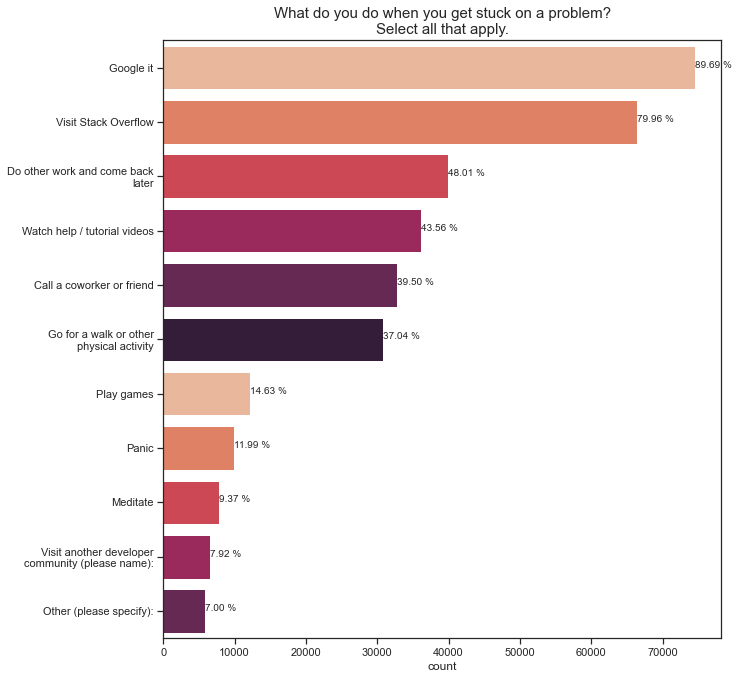

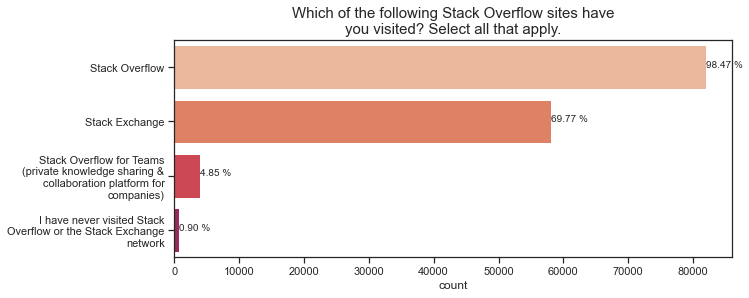

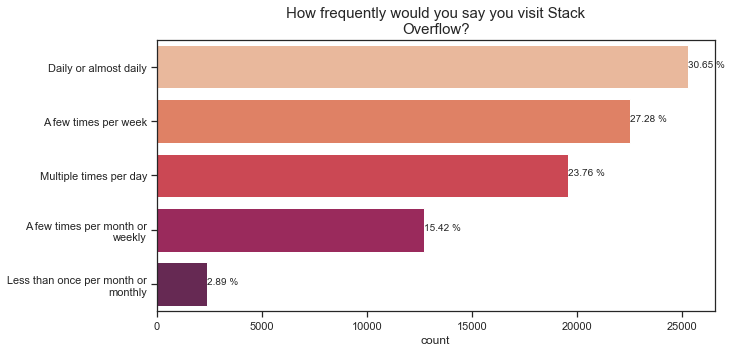

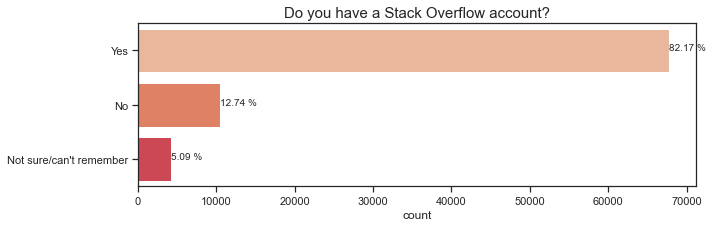

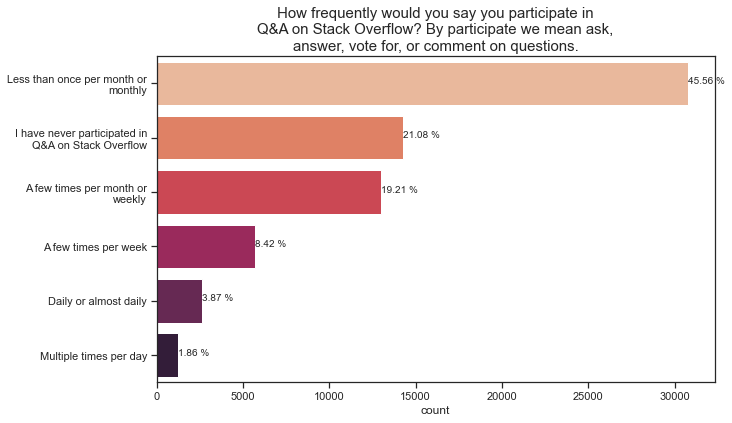

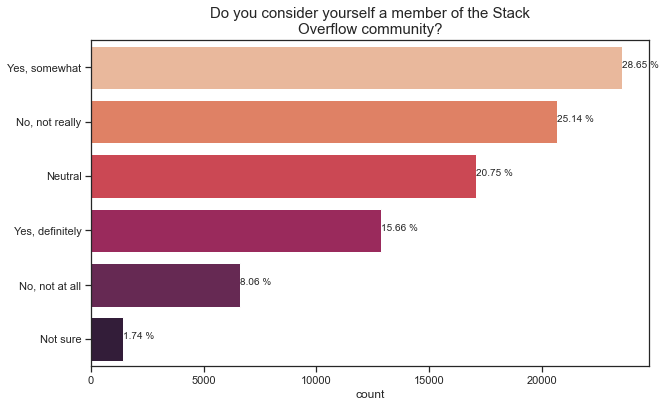

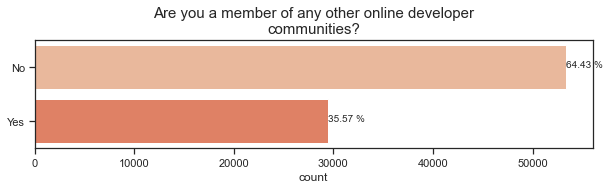

In [6]:
#Areas of interest: Community Users
#First I will plot the same information as in the official report:

for var in ['NEWStuck',
            'NEWSOSites',
            'SOVisitFreq',
            'SOAccount',
            'SOPartFreq',
            'SOComm',
            'NEWOtherComms']:
    plt.figure(figsize=(10,len(data[var].str.split(';', expand=True).stack().value_counts(normalize=True).index)))
    plt.title(textwrap.fill(data_schema.loc[data_schema['qname'] == var, 'question'].values[0], 50), fontsize=15)
    ax = plotbar_multi(data,var, order=True, palette=palette)
    


Those results are equivalent to the one reflected in the official report, and they confirm that our data and representation is accurate.

Now let's see if there is any difference when we segregate them by the developer type:

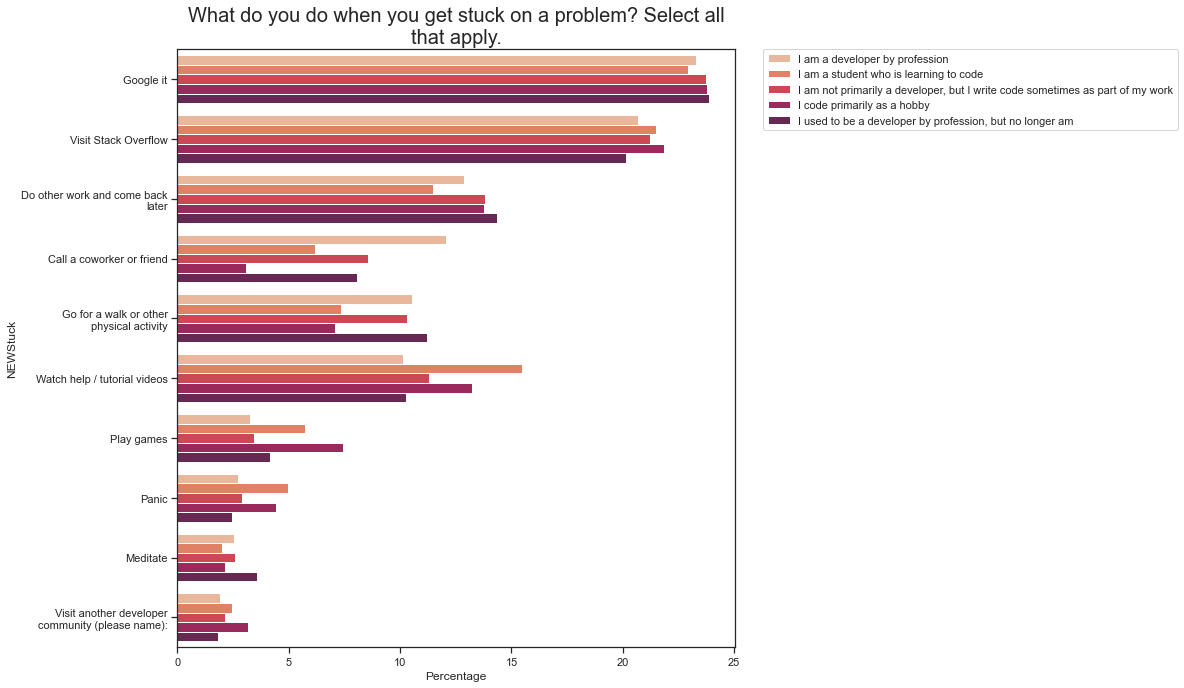

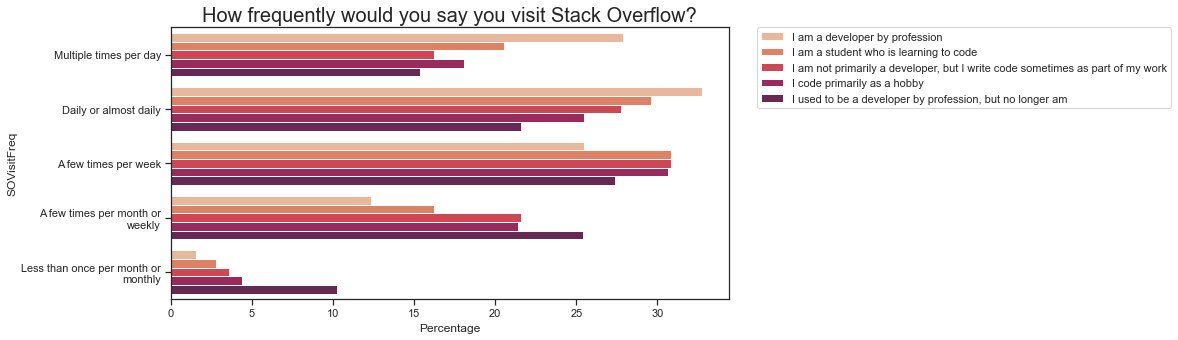

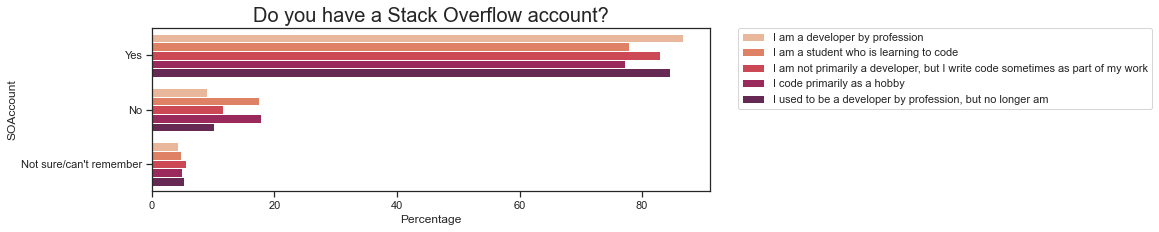

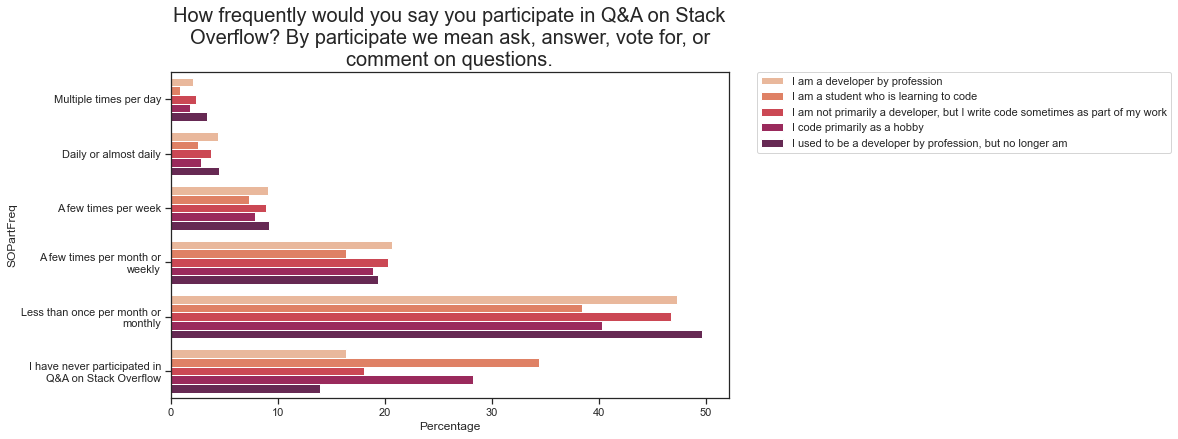

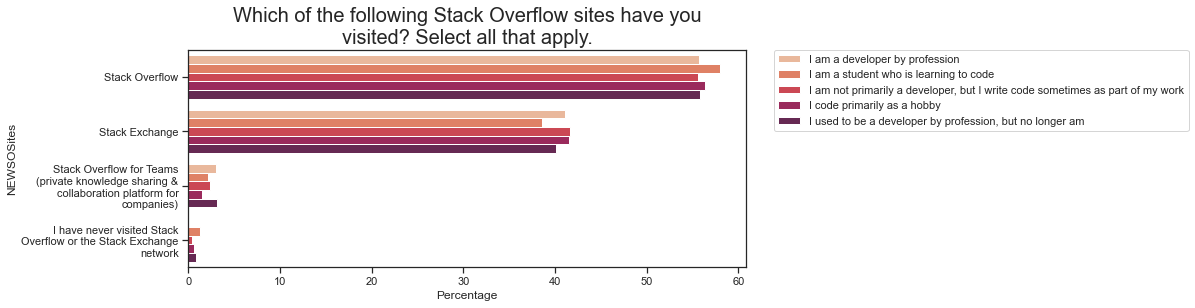

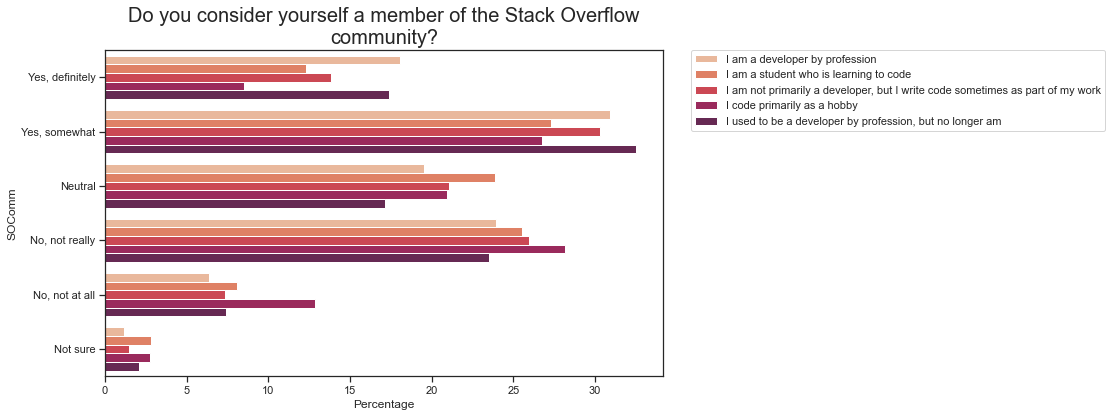

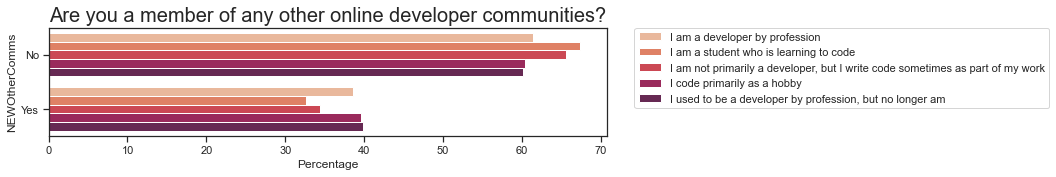

In [7]:
#MainBranch vs Uses Stack Overflow:

aux = df_explode(data,'NEWStuck')
aux = df_explode(aux.reset_index(drop=True),'Gender')
aux = df_explode(aux.reset_index(drop=True),'NEWSOSites')

filtr = ((aux['NEWStuck'] != 'Other (please specify):') & 
         (aux['Gender'] != 'Or, in your own words:') &
         (aux['MainBranch'] != 'None of these') #&
         #(aux['Country'].isin(select_top_n(data['Country'])))
          )

aux = aux.loc[filtr]


for var in ['NEWStuck',
            'SOVisitFreq',
            'SOAccount',
            'SOPartFreq',
            'NEWSOSites',
            'SOComm',
            'NEWOtherComms']:

        plt.figure(figsize=(10,len(data[var].str.split(';', expand=True).stack().value_counts(normalize=True).index)))

        # aux_2 = (aux.groupby(['MainBranch'])[var]
        #                 .value_counts(normalize=True)
        #                 .rename('Percentage')
        #                 .mul(100)
        #                 .reset_index()
        #                 .sort_values(var))
        # aux_2 = (aux.groupby([var])['MainBranch']
        #                 .value_counts(normalize=True)
        #                 .rename('Percentage')
        #                 .mul(100)
        #                 .reset_index()
        #                 .sort_values('MainBranch'))

        aux_2 = (aux.groupby(['MainBranch'],observed = True)[var].value_counts(normalize=True)
                                                            .mul(100)
                                                            .rename('Percentage')
                                                            .reset_index(level=0)
                                                            .reset_index(level=0)
                                                            .rename(columns={'index': var}))


        ax = sns.barplot( data=aux_2,
                        x='Percentage',
                        hue='MainBranch',
                        y=var,
                        orient='h',
                        palette=palette)
        # for idx, p in enumerate(ax.patches):
        #     per = val[idx]
        #     ax.annotate('{:.2f} %'.format(per), (p.get_width()+0.1, p.get_y()+p.get_height()))
        labelsy = [textwrap.fill(label.get_text(), 30) for label in ax.get_yticklabels()]
        ax.set_yticklabels(labelsy)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.title(textwrap.fill(data_schema.loc[data_schema['qname'] == var, 'question'].values[0], 60), fontsize=20)
       


We can see that generally, all the trends move together with the developer type with few exceptions:
#### Look for help:
* Professional developers usually have a coworker at hand to ask in case of doubts. It's an area to explore. Maybe we need to increase our collaborative tools in professional environments. 
* Students learning to code or people who code as a hobby usually looks for help using other online resources.

#### StackOverflow sites:
* There is no evident correlation with the developer profile

#### Visit frequency
* Developers are the ones that visit most frequently StackOverflow. It's a collective well attached to the StackOverflow environment.
* People that used to be developers are the least frequent on each time category. This is normal since they don't code, but maybe we can explore adding different content more attractive to ex-developers.

#### Have an account
* People who code (or have coded) professionally usually have an account on StackOverflow; however, some who code as a hobby or are studying don't have an account. 

#### Participation frequency
* Again, students and people who code as a hobby do not participate as frequently as developers. Maybe this is because they don't feel confident sharing knowledge or feel attracted by the website. We could explore other ways of participation for students and hobby developers. 
* However, most users have low participation, with a 67% of users participating once a month or less. StackOverflow is continuously trying to increase the users' participation. StackOverflow [badges are from 2008](https://stackoverflow.blog/2008/07/12/stack-overflow-badge-feedbac/) but yet, it's still not enough to achieve weekly/daily participation.

#### Feeling part of the community
*  In this case, there is a separation from non-professional developers. The people to code as a hobby do not generally feel part of the community, and the students feel a bit more integrated into the community.

#### Other developer communities
* There is no clear distinction between categories in this topic.

## Filtering the data

### What do you do when you get stuck in a problem?
This question can help us understand the profile of the users of StackOverflow. Since it is a multiple-choice question, the maximum doesn't mean that it is the first option by the users but the most common. We can filter the dataset by discarding those who visit StackOverflow to understand the users' profiles who do not visit us to look for help.
To understand our users, I'm going to focus on some demographics as: **Age**, **Gender**, **Employment**, **Education level**, **Continent** and **Country** for the top 5 more common countries. 

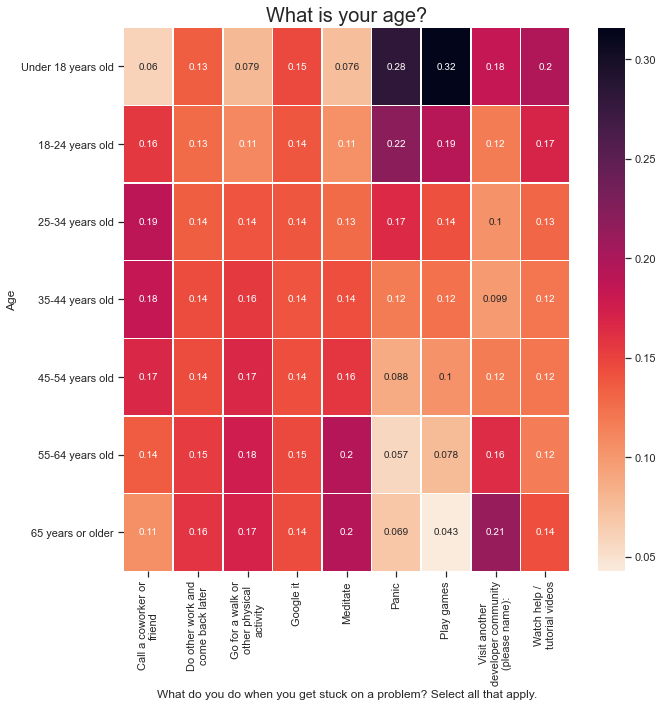

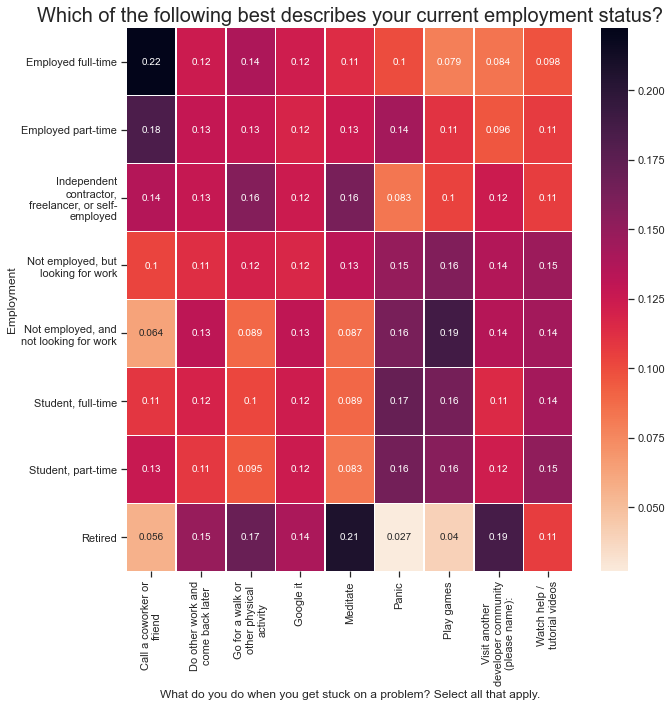

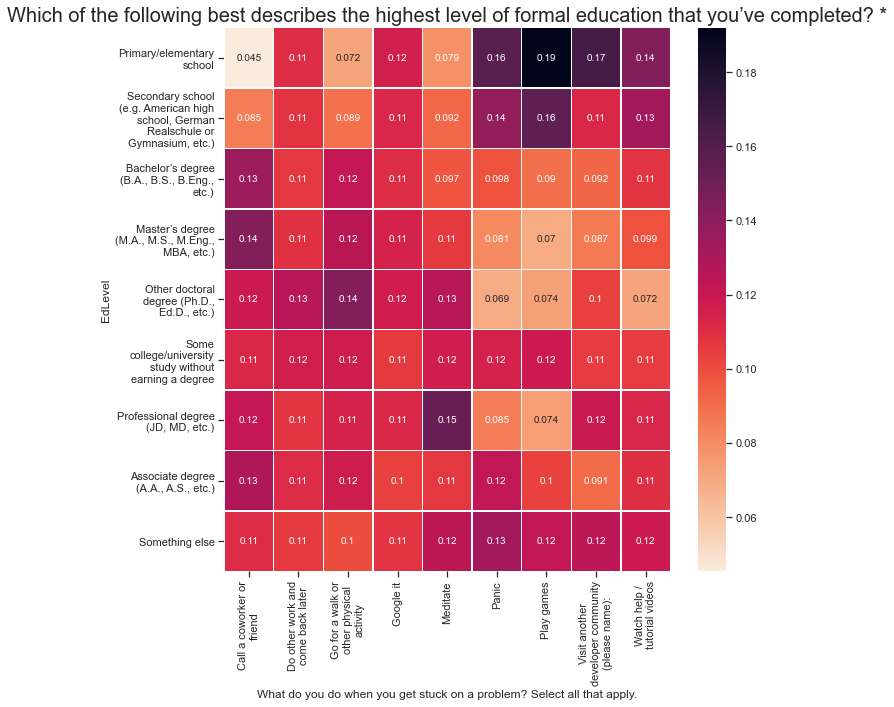

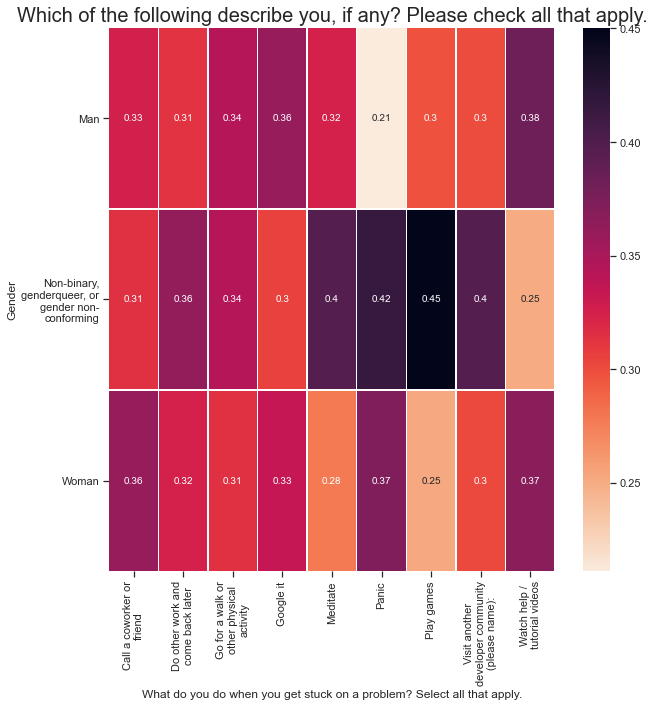

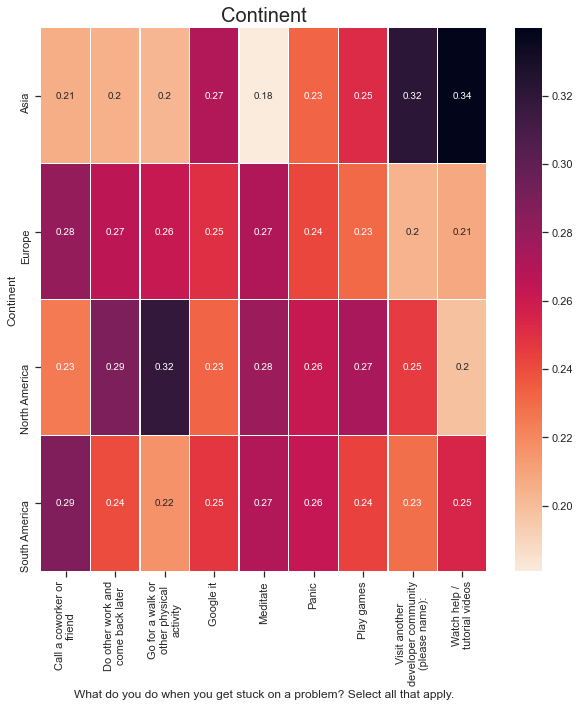

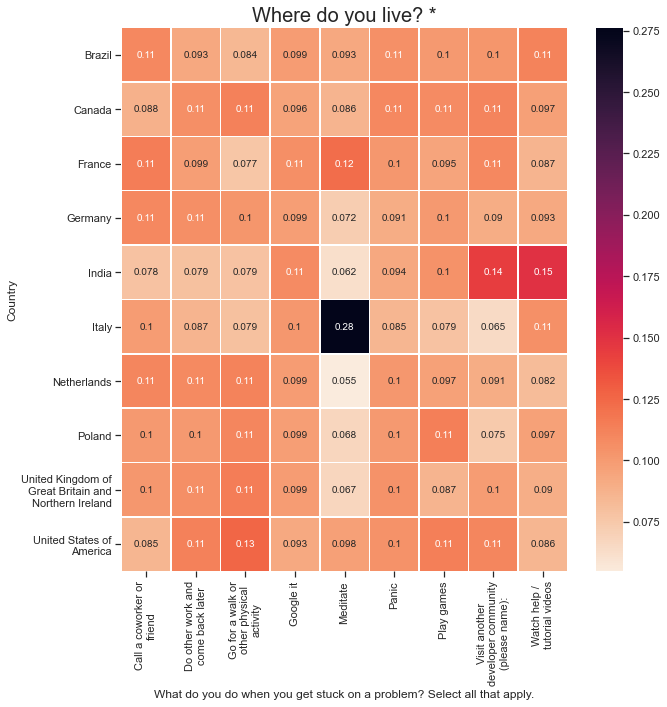

In [8]:
#Let's start with the ones that don't visit us:

aux = df_explode(data,'NEWStuck')
aux = df_explode(aux.reset_index(drop=True),'Gender')

filtr = ((~aux['NEWStuck'].isna()) & (aux['NEWStuck'] != 'Visit Stack Overflow') &
         (aux['NEWStuck'] != 'Other (please specify):') & 
         (aux['Gender'] != 'Or, in your own words:') &
         (aux['Gender'] != 'Prefer not to say') &
         (aux['Age'] != 'Prefer not to say') &
         (aux['Employment'] != 'I prefer not to say') &
         (aux['Country'].isin(select_top_n(data['Country'],10))) )

aux = aux.loc[filtr]
var_to_study = 'NEWStuck'

#Let's plot their Age, their Employment, Education Level:

for var in ['Age',
            'Employment',
            'EdLevel',
            'Gender',
            'Continent',
            'Country']:

    aux_2 = (aux.groupby([var],observed = True )[var_to_study]
                            .value_counts(normalize=True)
                            .rename('Percentage')
                            .mul(100)
                            .reset_index(level=0)
                            .reset_index(level=0)
                            .rename(columns={'index': var_to_study}))
    aux_3 = df_row_normalize(aux_2.pivot(index=var_to_study, columns=var, values='Percentage'))
    fig = plt.figure(figsize=(10,10), )
    ax = sns.heatmap(aux_3.T,cmap=cmap, annot=True, fmt='.2g', linewidths=.5)
    plt_wraplabel(ax)
    plt.title(data_schema.loc[data_schema['qname'] == var, 'question'].values[0], fontsize=20)
    plt.xlabel(data_schema.loc[data_schema['qname'] == var_to_study, 'question'].values[0])


    




The above plots show the following features:


#### Age
* We can see that the youngest on our dataset usually panic or get distracted playing video games. It's the expected behaviour of people from that age range. However, we also see that some of them usually watch videos to find solutions; this trend decreases with age, older people watch fewer videos than younger, and it agrees with the SO official results. 
* People of the working-age look for help from friends and coworkers, visibly clear on the employment chart. 
* The oldest in our dataset prefer to meditate or visit another community, and only a tiny fraction prefer to play video games when they are stuck in a problem.

#### Employment
* As noted on the age range, clearly employed people (full or part-time) seeking help from colleagues or friends is the most common source. SO already launched [StackOverflow for teams](https://stackoverflow.com/teams) in 2018 to exploit this weakness, but it's still an area to study and improve.
* Students and non-working people are the ones that mostly looks for help watching videos, and this trend is correlated with the age chart.
* Retired people usually go for a walk, meditate, or visit another community and again, the age chart validates this.

#### Education Level
* Similar results as with the age plot are shown for the youngest categories. They play games, panic, visit another community and watch video tutorials. We could consider using those channels if we want to target this collective. 
* Bachelor's and Masters often look for help from colleagues or friends. 
* People with a high level of studies (Master's degree or doctoral degree) tend not to panic nor play video games.
* People with professional degrees usually meditates to solve problems.

#### Gender
* There is no useful information on this plot. Things to note: the "Non-binary, genderqueer, or gender non-conforming" category tend to panic and play games to face problems.

#### Continent
* With the continent distribution, we can see that most people from Asia that don't visit SO look for help on videos. They also generally visit another community. Those mediums could be our target if we want to increase our activity on this continent. 
* People from Europe and South America are more often called a coworker. This could give a lead on where to target the SO for teams. 
* In North America, people usually go for a walk or continue later with the problem.

#### Country
*  Directly correlates to the continent chart, and it doesn't give specific information.
*  Something interesting, people from Italy are the ones that most meditates over the top 10 countries. 
  

### How frequently would you say you visit Stack Overflow?
This is another exciting point of view. Before, we analyzed the people that don't visit SO when they have a problem. But for those who do it, it is also interesting to explore how frequently they do it to find more weaknesses. WE are going to use the same demographics as before.

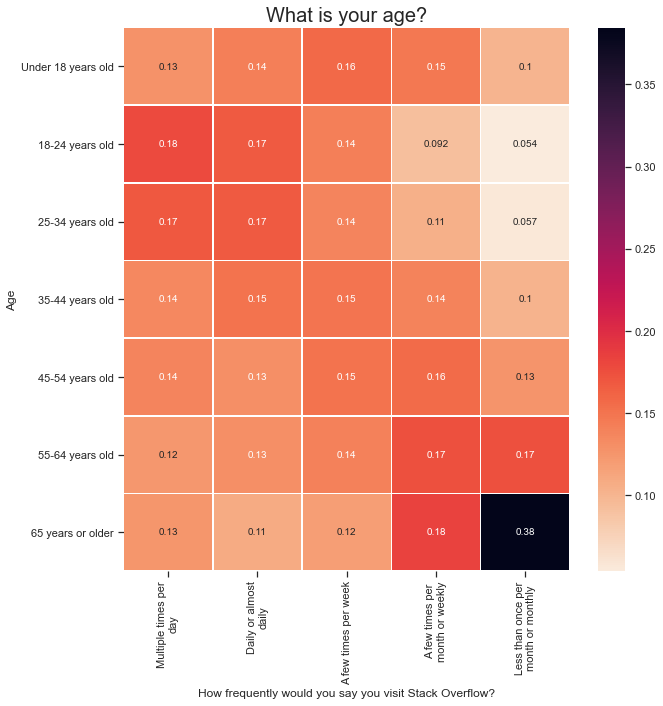

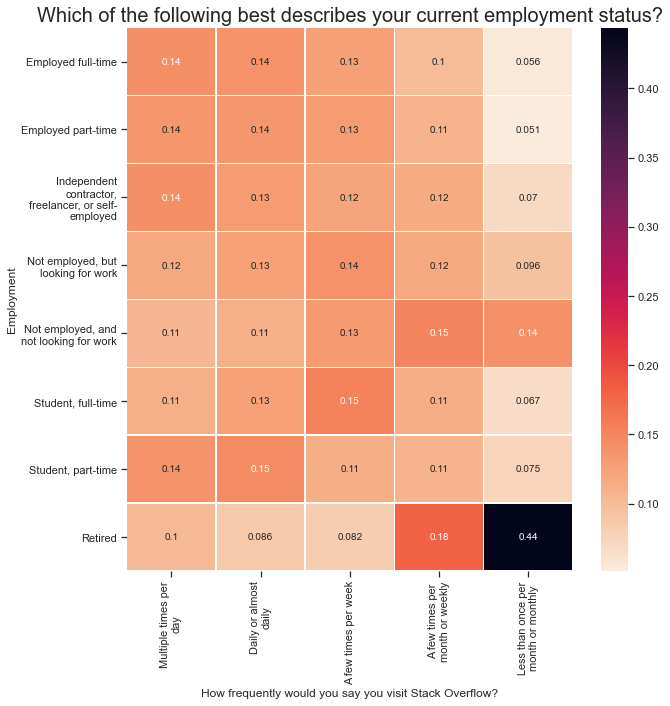

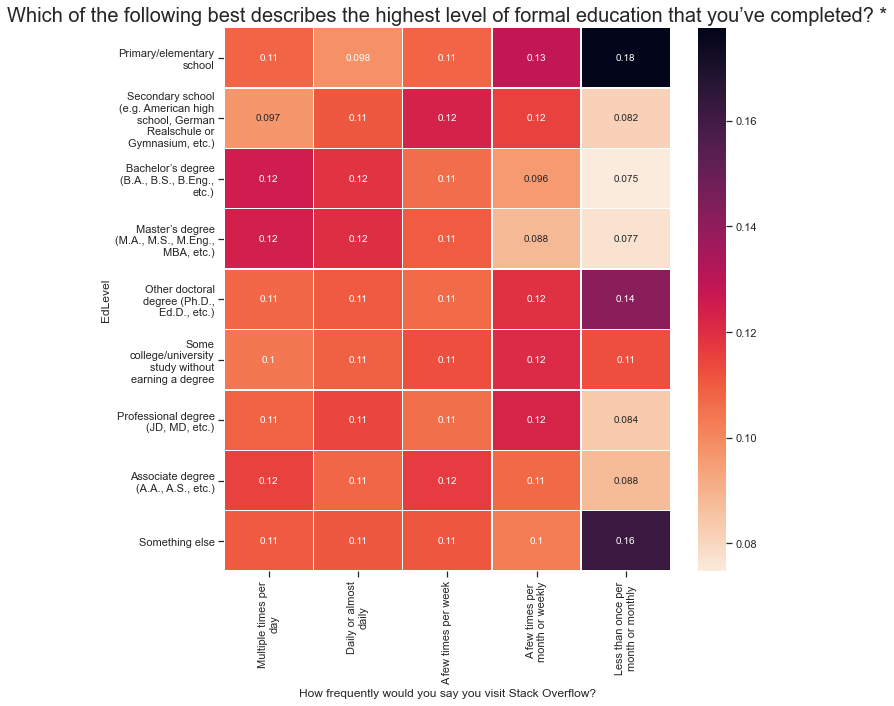

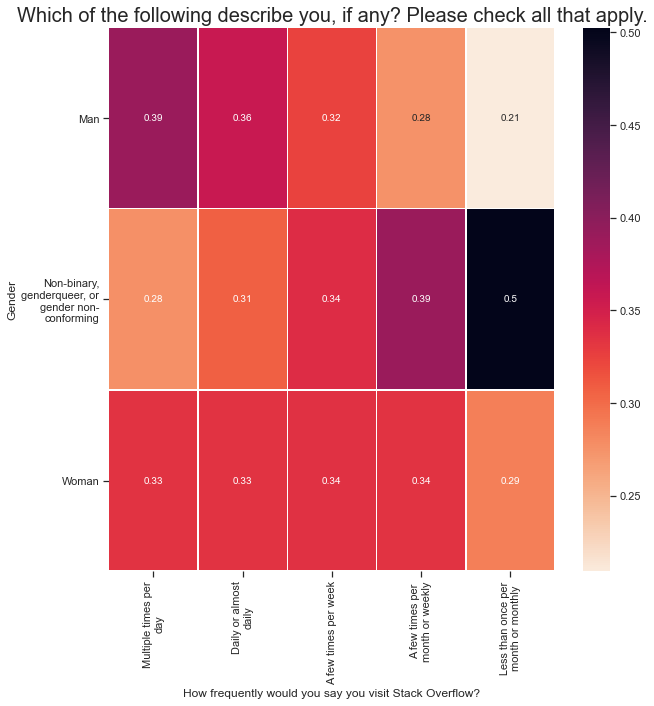

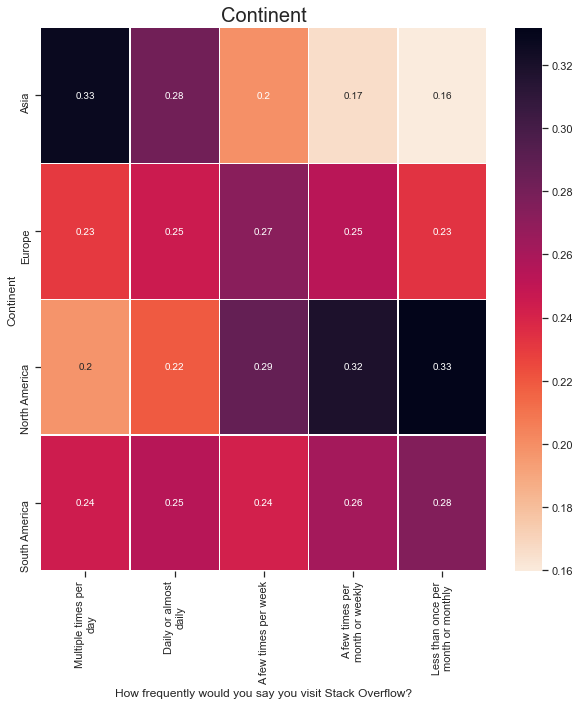

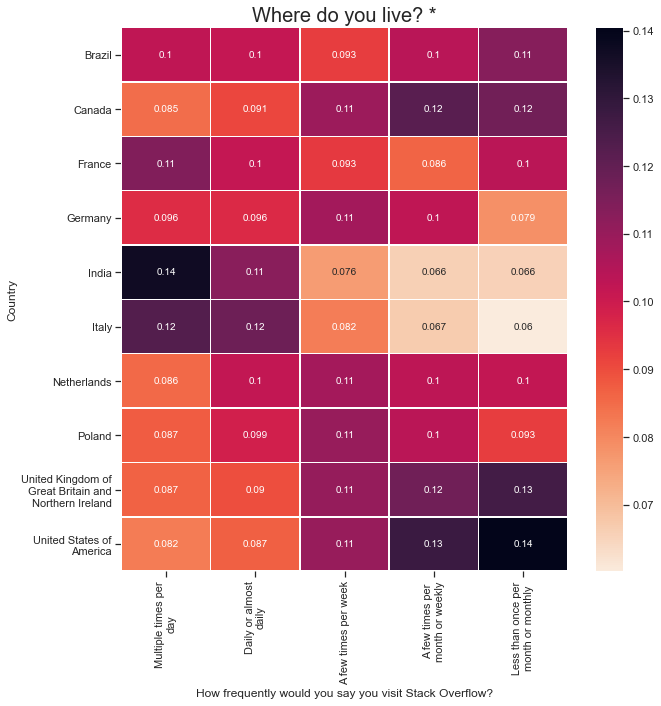

In [9]:
      
#We can do the same analysis with the visit frequency:

aux = df_explode(data,'NEWStuck')
aux = df_explode(aux.reset_index(drop=True),'Gender')


#Those do not bring us information:
filtr = ((~aux['NEWStuck'].isna()) & #(aux['NEWStuck'] != 'Visit Stack Overflow') &
         (aux['NEWStuck'] != 'Other (please specify):') & 
         (aux['Gender'] != 'Or, in your own words:') &
         (aux['Gender'] != 'Prefer not to say') &
         (aux['Age'] != 'Prefer not to say') &
         (aux['Employment'] != 'I prefer not to say') &
         (aux['Country'].isin(select_top_n(data['Country'],10))) )

aux = aux.loc[filtr]

#Let's plot their Age, their Employment, Education Level:

var_to_study = 'SOVisitFreq'

for loop_var in ['Age',
            'Employment',
            'EdLevel',
            'Gender',
            'Continent',
            'Country']:

    aux_2 = (aux.groupby([loop_var],observed = True)[var_to_study].value_counts(normalize=True)
                                                                .mul(100)
                                                                .rename('Percentage')
                                                                .reset_index(level=0)
                                                                .reset_index(level=0)
                                                                .rename(columns={'index': var_to_study}))

    aux_3 = df_row_normalize(aux_2.pivot(index=var_to_study, columns=loop_var, values='Percentage'))
    fig = plt.figure(figsize=(10,10) )
    ax = sns.heatmap(aux_3.T,cmap=cmap, annot=True, fmt='.2g', linewidths=.5)
    plt_wraplabel(ax)
    plt.title(data_schema.loc[data_schema['qname'] == loop_var, 'question'].values[0], fontsize=20)
    plt.xlabel(data_schema.loc[data_schema['qname'] == var_to_study, 'question'].values[0])
  

The above plots show the following features:


#### Age
* The most remarkable thing in this plot is the +65 group. Among all the other categories, they are the ones that visit the least SO. Maybe they don't need to look for information, perhaps they don't feel attracted to the content of our website, or they don't know how to use it. This trend starts at the +55 group with less participation than the other age groups. This is an area to explore, and the Employment plot will corroborate it.
* People from 18 to 34 are the ones that visit more frequently SO.

#### Employment
* Usually retired people are from the +65 years old group, and this plot throws similar results as the previous one. 
* The rest of the chart is generally homogeneous, with working people visiting SO more frequently than non-working people. 
* Most of the members of each group visit SO more frequently than a few times per month, except for the "Not employed, and not looking for work" group.

#### Education Level
* Regarding the education level, people with an education level of Primary/elementary school, usually kids, are the ones that visit the least SO. This is another area to explore if we want to increase the participation of the youngest.
* People with a high level of studies tend to visit SO more often than others. 
* Actually, we can see a trend line in the frequency of the visits with age. 

#### Gender
* People that feel as "Non-binary, genderqueer, or gender non-conforming" are the ones that visit the least often SO. This is an interesting point of view that will need deeper analysis, and maybe SO is not inclusive enough to attract this collective. 
* The inverse trend is shown for men.

#### Continent
* We can see horizontal trend lines from Asia (led by India as shown in the country plot) and North America; being the people from Asia the ones that visit more often SO and the people from North America the ones that visit SO less frequent. 
* Europe and South America are homogeneously distributed.

#### Country
* If we go deeper in granularity, we see that effectively, users from India are the ones that visit SO more frequently, followed by Italy.
* On the other hand, people from the USA, the UKI and Canada are the ones that visit less frequently SO.
* The other countries have a homogeneous or normal distribution.
  

### Differences in users that have an account

The users who have an account and those who don't are equally distributed among the different categories under the study. Therefore, no results are shown. The code is left commented in the following code block:


In [10]:
# aux = df_explode(data,'Gender')

# filtr = ((aux['Gender'] != 'Or, in your own words:') &
#         (aux['SOAccount'] != 'Not sure/can\'t remember') &
#         (aux['Gender'] != 'Prefer not to say') &
#         (aux['Age'] != 'Prefer not to say') &
#         (aux['Employment'] != 'I prefer not to say') &
#         (aux['Country'].isin(select_top_n(data['Country'],10))) )

# aux = aux.loc[filtr]

# var_to_study = 'SOAccount'

# for loop_var in ['Age',
#                 'Employment',
#                 'EdLevel',
#                 'Gender',
#                 'Continent',
#                 'Country']:

        
        
#         aux_2 = (aux.groupby([var_to_study],observed = True)[loop_var].value_counts().apply(lambda x: x/x)
#                                                             .mul(100)
#                                                             .rename('Percentage')
#                                                             .reset_index(level=0)
#                                                             .reset_index(level=0)
#                                                             .rename(columns={'index': loop_var}))


#         aux_3 = df_row_normalize(aux_2.pivot(index=var_to_study, columns=loop_var, values='Percentage'))
#         fig = plt.figure(figsize=(10,10) )
#         ax = sns.heatmap(aux_3.T,cmap=cmap, annot=True, fmt='.2g', linewidths=.5)
#         plt_wraplabel(ax)
#         plt.title(data_schema.loc[data_schema['qname'] == loop_var, 'question'].values[0], fontsize=20)
#         plt.xlabel(data_schema.loc[data_schema['qname'] == var_to_study, 'question'].values[0])        


### Interactions with on SO
Similar to the visit frequency category, this question goes a bit deeper, trying to understand if the users who visit their site interact with it. This helps to understand the profile of the "active" users, and it will help us identify the users that only visit the site but barely interact.

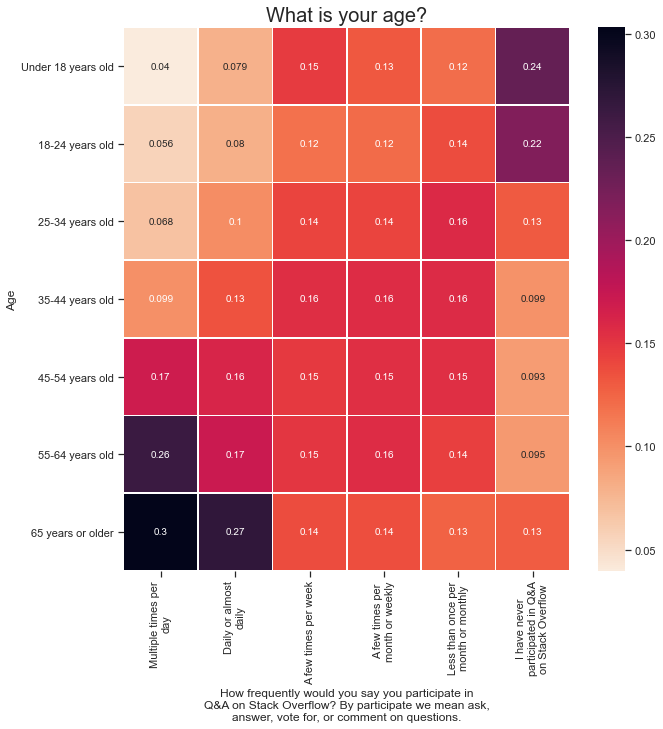

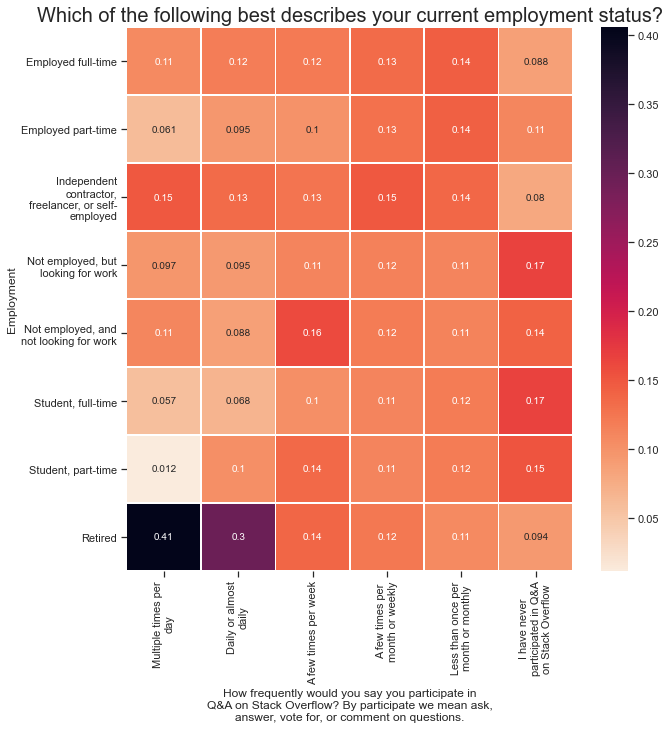

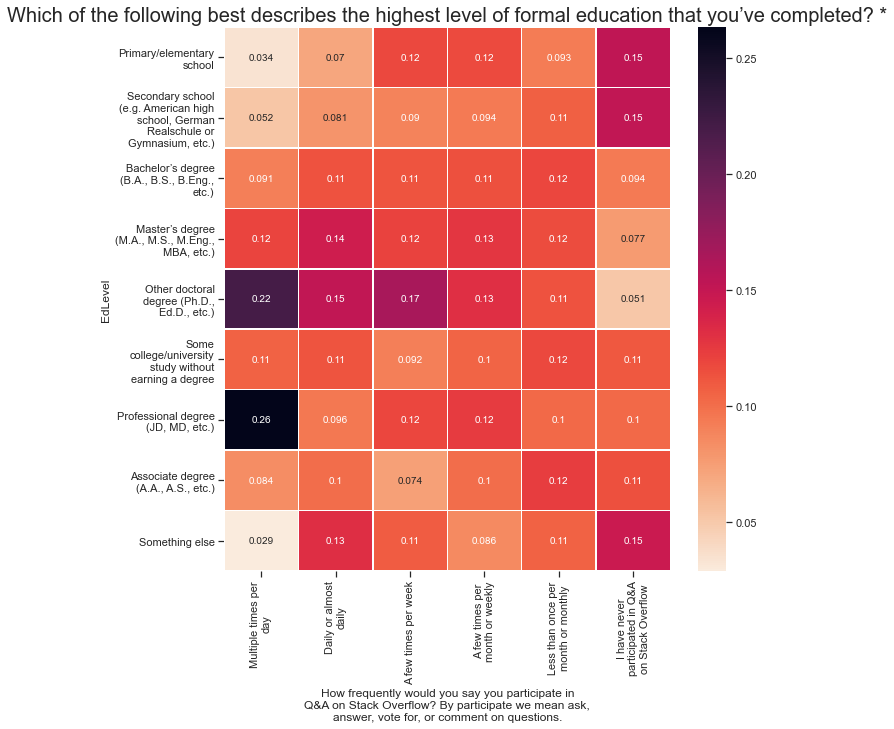

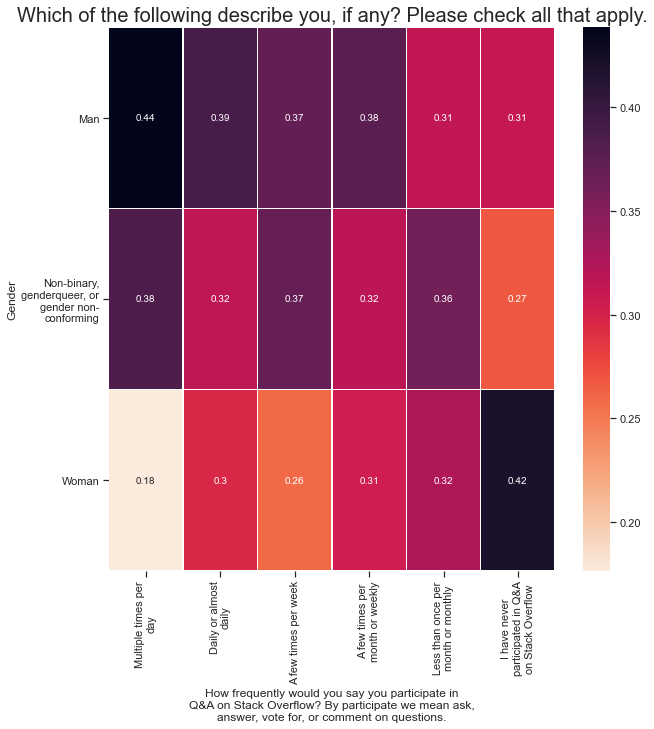

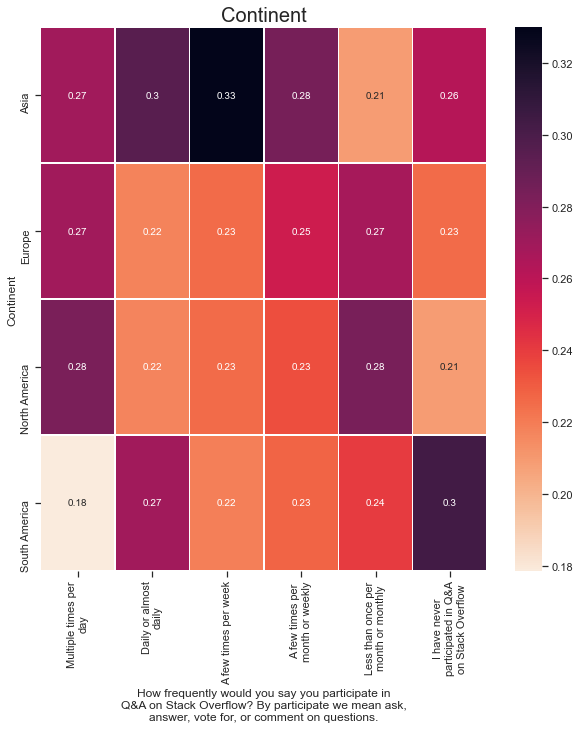

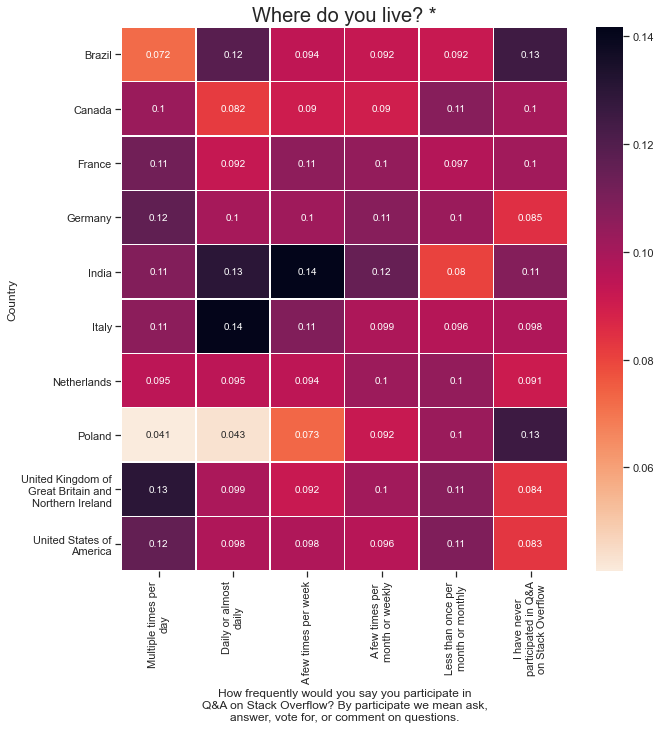

In [11]:
#Running the analysis for the participation frequency:

aux = df_explode(data,'NEWStuck')
aux = df_explode(aux.reset_index(drop=True),'Gender')


#Those do not bring us information:
filtr = ((~aux['NEWStuck'].isna()) & #(aux['NEWStuck'] != 'Visit Stack Overflow') &
         (aux['NEWStuck'] != 'Other (please specify):') & 
         (aux['Gender'] != 'Or, in your own words:') &
         (aux['Gender'] != 'Prefer not to say') &
         (aux['Age'] != 'Prefer not to say') &
         (aux['Employment'] != 'I prefer not to say') &
         (aux['Country'].isin(select_top_n(data['Country'],10))) )

aux = aux.loc[filtr]

#Let's plot their Age, their Employment, Education Level:

var_to_study = 'SOPartFreq'

for loop_var in ['Age',
            'Employment',
            'EdLevel',
            'Gender',
            'Continent',
            'Country']:

    aux_2 = (aux.groupby([loop_var],observed = True)[var_to_study].value_counts(normalize=True)
                                                                .mul(100)
                                                                .rename('Percentage')
                                                                .reset_index(level=0)
                                                                .reset_index(level=0)
                                                                .rename(columns={'index': var_to_study}))

    aux_3 = df_row_normalize(aux_2.pivot(index=var_to_study, columns=loop_var, values='Percentage'))
    fig = plt.figure(figsize=(10,10) )
    ax = sns.heatmap(aux_3.T,cmap=cmap, annot=True, fmt='.2g', linewidths=.5)
    plt_wraplabel(ax)
    plt.title(data_schema.loc[data_schema['qname'] == loop_var, 'question'].values[0], fontsize=20)
    plt.xlabel(textwrap.fill(data_schema.loc[data_schema['qname'] == var_to_study, 'question'].values[0], 50))

The above plots show the following features:


#### Age
* This is an insightful heatmap with a clear and well-defined trend from young users interacting very lowly to old users interacting the most frequently.

#### Employment
* Regarding the employment chart, it's worth noticing that retired people are predominant from the users who interact more often. This result is not incompatible with the previous plot since it doesn't mean that most retired people interact multiple times a day. Instead, it means that, from the people that interact various times per day, 41% are retired. The same is applicable for those that interact daily or almost daily. 
* Students and people willing to work, but not currently working; are the ones that interact the least

#### Education Level
* People holding a doctoral or a professional degree are the ones that interact the most.
* People with high-level of education tend to interact more than the rest of the categories
* The persons holding a Primary and Secondary education level are the ones that interact the less. Again, this area needs more exploration to attract this collective. 

#### Gender
* Men generally interact more than women.

#### Continent
* South America is the continent with less interaction
* North America has the users that interact the most.
* In Asia is distributed around a few times per week.

#### Country
* Generally homogeneous except for Poland, which has users who interact the least over the top 10 countries.

### StackOverflow sites
We will quickly analyze this category since it shows results similar to the ones we already discussed:

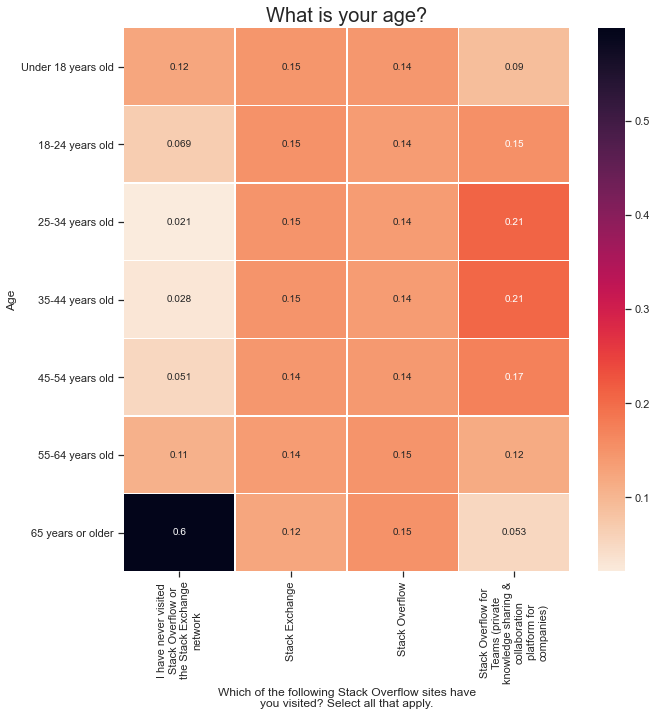

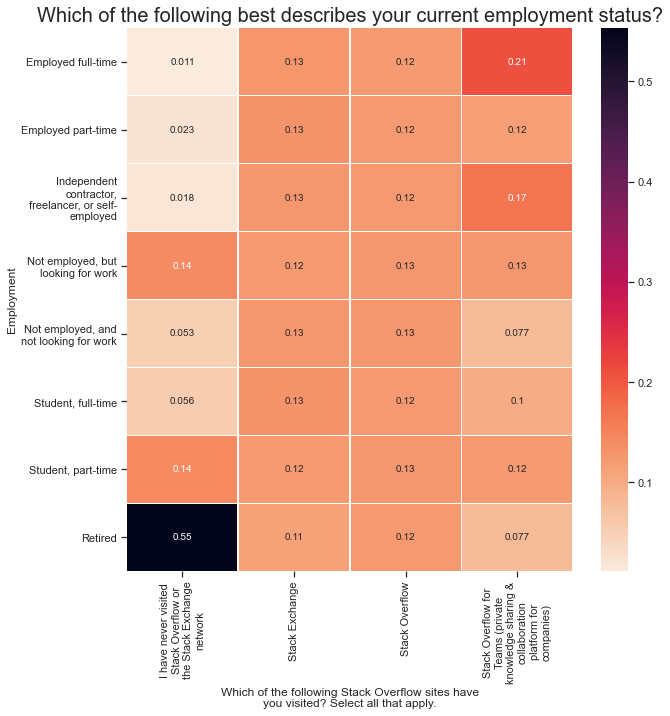

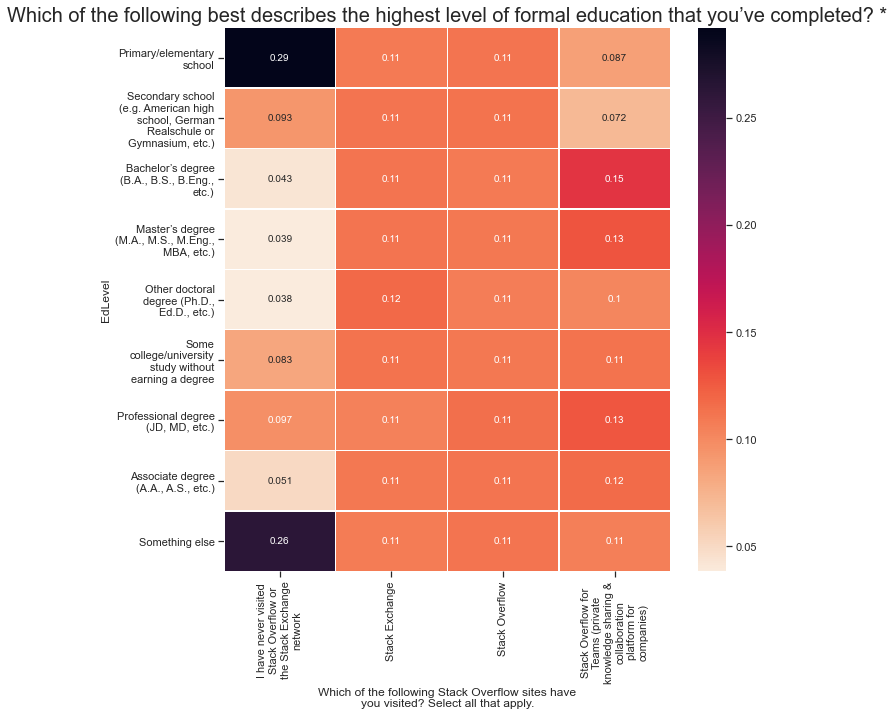

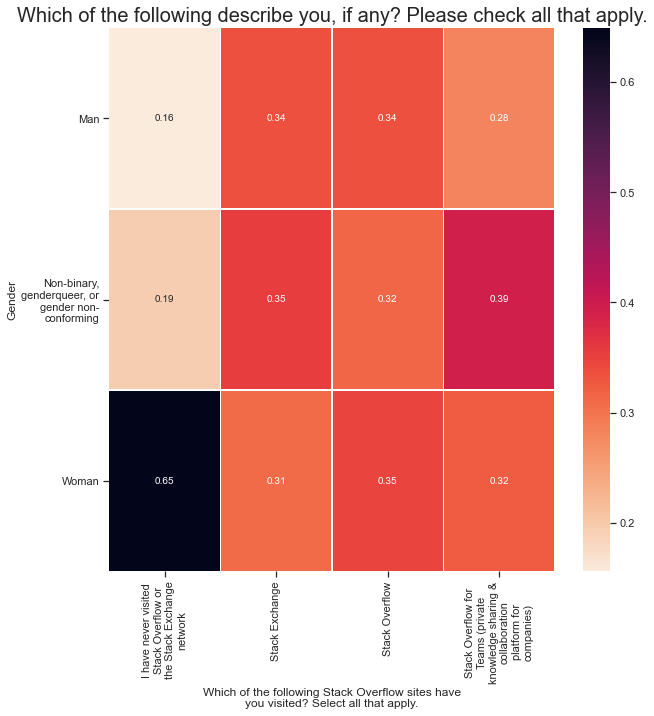

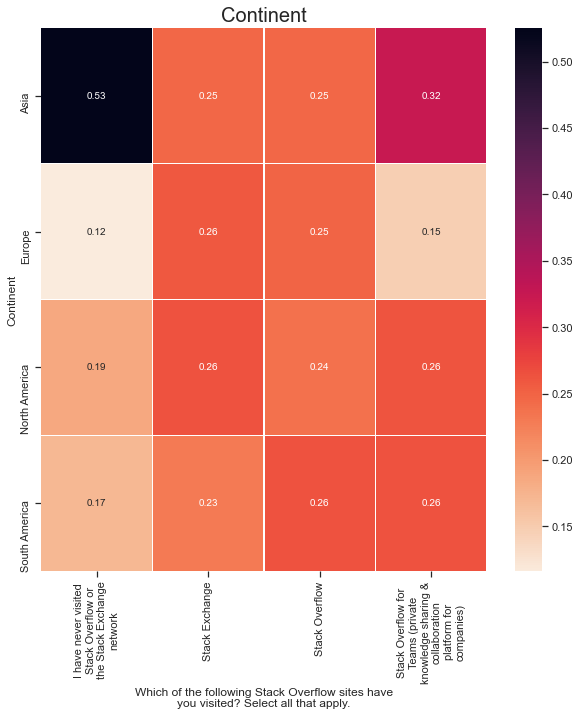

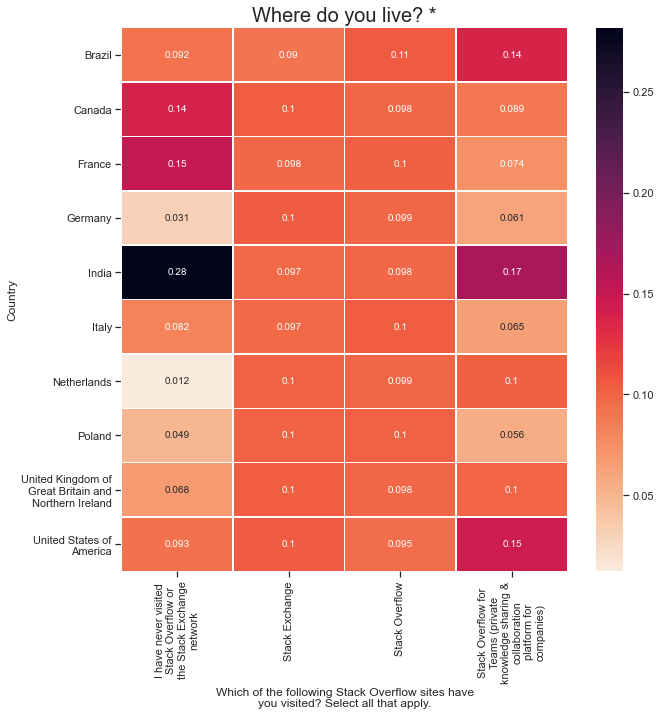

In [12]:
aux = df_explode(data,'NEWSOSites')
aux = df_explode(aux.reset_index(drop=True),'Gender')


#Those do not bring us information:
filtr = ((~aux['NEWSOSites'].isna()) & #(aux['NEWStuck'] != 'Visit Stack Overflow') &
         (aux['NEWStuck'] != 'Other (please specify):') & 
         (aux['Gender'] != 'Or, in your own words:') &
         (aux['Gender'] != 'Prefer not to say') &
         (aux['Age'] != 'Prefer not to say') &
         (aux['Employment'] != 'I prefer not to say') &
         (aux['Country'].isin(select_top_n(data['Country'],10))) )

aux = aux.loc[filtr]

#Let's plot their Age, their Employment, Education Level:

var_to_study = 'NEWSOSites'

for loop_var in ['Age',
            'Employment',
            'EdLevel',
            'Gender',
            'Continent',
            'Country']:

    aux_2 = (aux.groupby([loop_var],observed = True)[var_to_study].value_counts(normalize=True)
                                                                .mul(100)
                                                                .rename('Percentage')
                                                                .reset_index(level=0)
                                                                .reset_index(level=0)
                                                                .rename(columns={'index': var_to_study}))

    aux_3 = df_row_normalize(aux_2.pivot(index=var_to_study, columns=loop_var, values='Percentage'))
    fig = plt.figure(figsize=(10,10) )
    ax = sns.heatmap(aux_3.T,cmap=cmap, annot=True, fmt='.2g', linewidths=.5)
    plt_wraplabel(ax)
    plt.title(data_schema.loc[data_schema['qname'] == loop_var, 'question'].values[0], fontsize=20)
    plt.xlabel(textwrap.fill(data_schema.loc[data_schema['qname'] == var_to_study, 'question'].values[0], 50))

#### Age and Employment
* Similar to before, the older categories are the majority among those who never visited any SO sites.
* Workers or people of working age are the most significant part of those who have used SO  for Teams.

#### Education Level
* Bachelor's degree holders are the ones that have used SO for Teams more frequently.
* And Primary School group are the main group that neve visited SO.

#### Gender
* Women are the most common gender that never visited SO

#### Continent & Country
* India is the country with most users never visiting SO, followed by France and Canada. Again, this is not against them being the users who visit SO more often. This number means that, from those who never visited SO, 28% are from India. They are also the majority of people that have used SO for teams, together with the USA and Brazil

### Feeling part of the community

Most of the plots contained no-relevant information or were not correlated. The only interesting figure is the classification by country, where we can see a clear trend in India, with them being the ones that consider themselves part of the community. The code to generate the rest of the plots is included on the following code block, but it's commented.

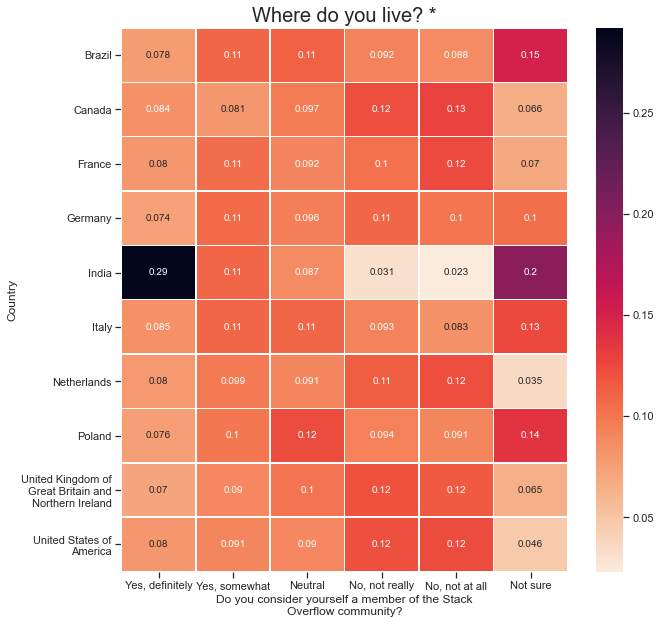

In [13]:

aux = df_explode(data,'Gender')


#Those do not bring us information:
filtr = ((aux['NEWStuck'] != 'Other (please specify):') & 
         (aux['Gender'] != 'Or, in your own words:') &
         (aux['Gender'] != 'Prefer not to say') &
         (aux['Age'] != 'Prefer not to say') &
         (aux['Employment'] != 'I prefer not to say') &
         (aux['Country'].isin(select_top_n(data['Country'],10))) )

aux = aux.loc[filtr]

#Let's plot their Age, their Employment, Education Level:

var_to_study = 'SOComm'

for loop_var in ['Country',  #Only Country is shown since there was no relevant information on the others
        #     'Age',
        #     'Employment',
        #     'EdLevel',
        #     'Gender',
        #     'Continent',
        #     'Country'
            ]:

    aux_2 = (aux.groupby([loop_var],observed = True)[var_to_study].value_counts(normalize=True)
                                                                .mul(100)
                                                                .rename('Percentage')
                                                                .reset_index(level=0)
                                                                .reset_index(level=0)
                                                                .rename(columns={'index': var_to_study}))

    aux_3 = df_row_normalize(aux_2.pivot(index=var_to_study, columns=loop_var, values='Percentage'))
    fig = plt.figure(figsize=(10,10) )
    ax = sns.heatmap(aux_3.T,cmap=cmap, annot=True, fmt='.2g', linewidths=.5)
    plt_wraplabel(ax)
    plt.title(data_schema.loc[data_schema['qname'] == loop_var, 'question'].values[0], fontsize=20)
    plt.xlabel(textwrap.fill(data_schema.loc[data_schema['qname'] == var_to_study, 'question'].values[0], 50))

### Member of other community

* People from 18 to 34 usually are not part of other developer communities.
* The categories: 
  - Independent contractor, freelance, or self-employed
  - Professional degree
  - Non-binary, genderqueer, or gender non-conforming
  - USA and Brazil

  are the categories with the most users that are members of another online developer community. The following plots show those results:

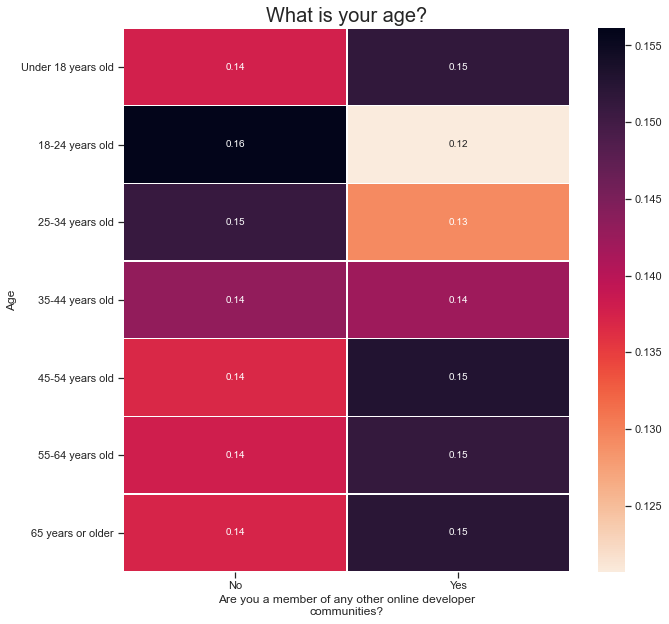

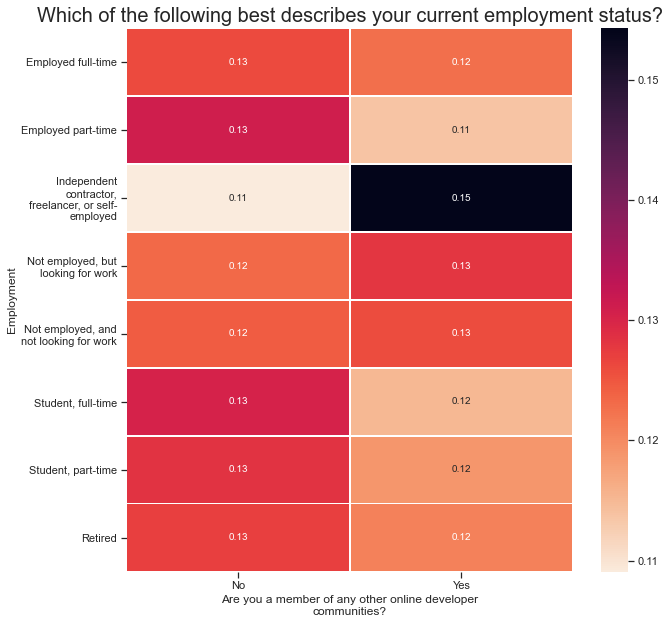

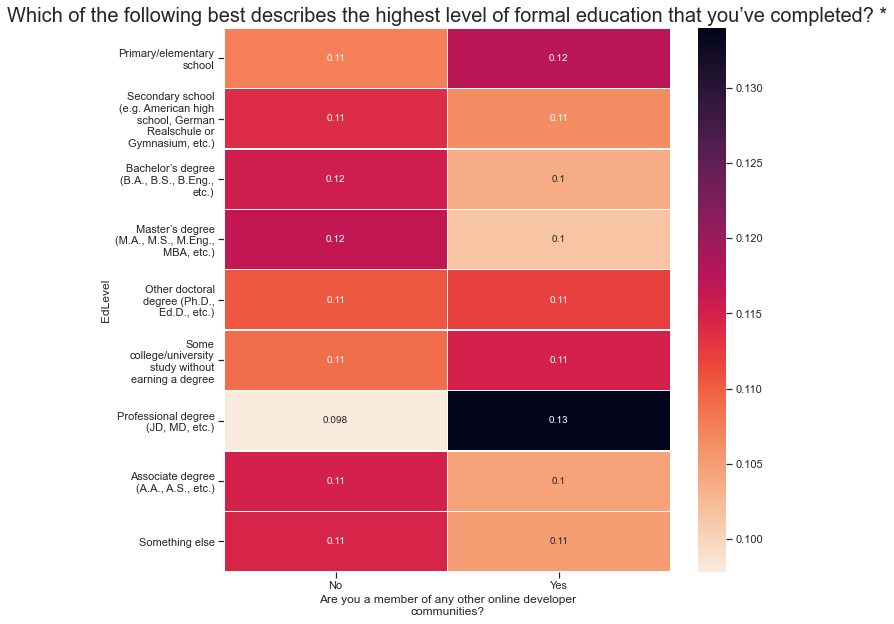

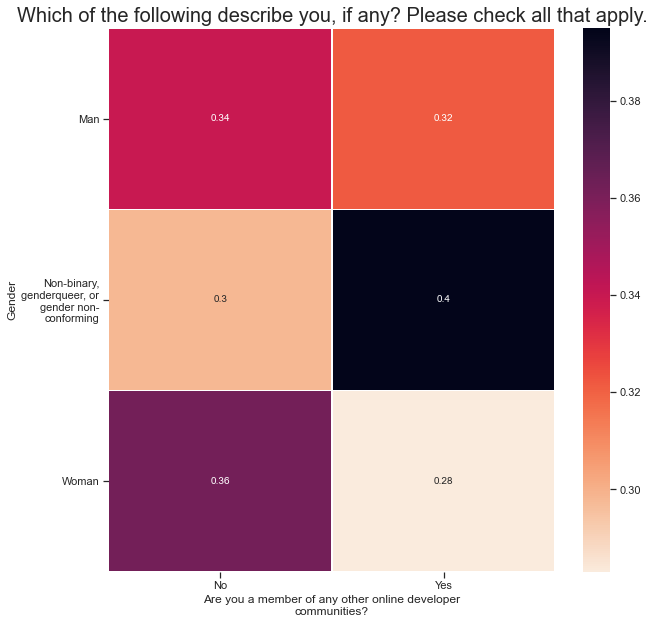

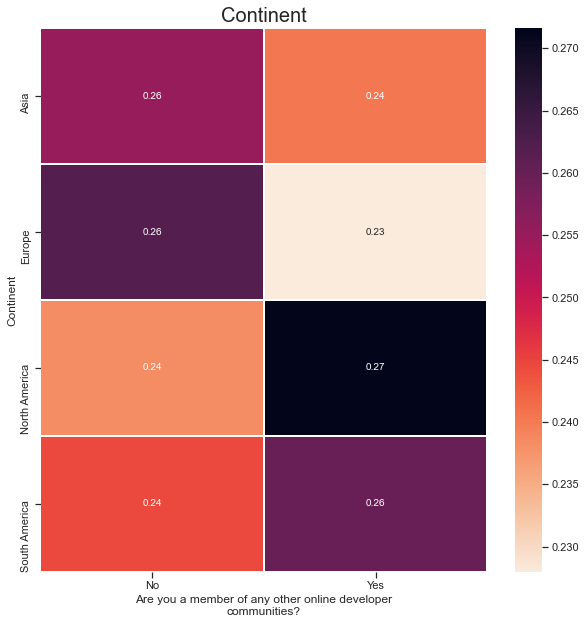

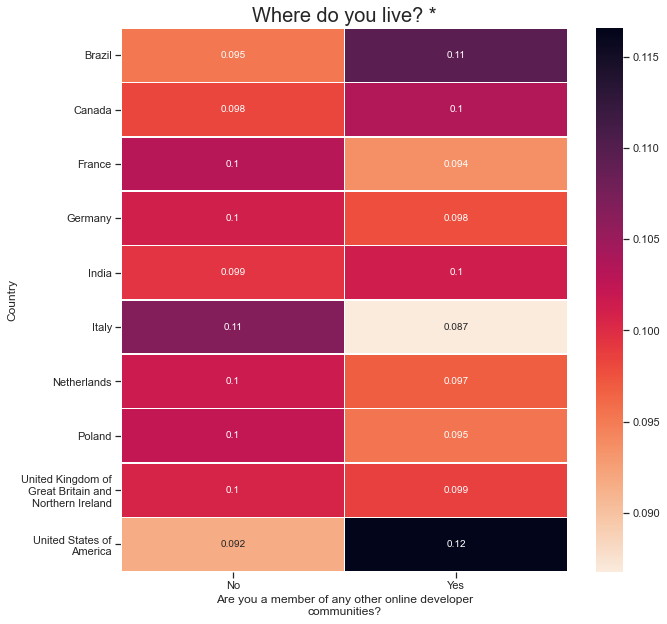

In [14]:
aux = df_explode(data,'Gender')


#Those do not bring us information:
filtr = ((aux['NEWStuck'] != 'Other (please specify):') & 
         (aux['Gender'] != 'Or, in your own words:') &
         (aux['Gender'] != 'Prefer not to say') &
         (aux['Age'] != 'Prefer not to say') &
         (aux['Employment'] != 'I prefer not to say') &
         (aux['Country'].isin(select_top_n(data['Country'],10))) )

aux = aux.loc[filtr]

#Let's plot their Age, their Employment, Education Level:

var_to_study = 'NEWOtherComms'

for loop_var in ['Age',
                'Employment',
                'EdLevel',
                'Gender',
                'Continent',
                'Country']:

    aux_2 = (aux.groupby([loop_var],observed = True)[var_to_study].value_counts(normalize=True)
                                                                .mul(100)
                                                                .rename('Percentage')
                                                                .reset_index(level=0)
                                                                .reset_index(level=0)
                                                                .rename(columns={'index': var_to_study}))

    aux_3 = df_row_normalize(aux_2.pivot(index=var_to_study, columns=loop_var, values='Percentage'))
    fig = plt.figure(figsize=(10,10) )
    ax = sns.heatmap(aux_3.T,cmap=cmap, annot=True, fmt='.2g', linewidths=.5)
    plt_wraplabel(ax)
    plt.title(data_schema.loc[data_schema['qname'] == loop_var, 'question'].values[0], fontsize=20)
    plt.xlabel(textwrap.fill(data_schema.loc[data_schema['qname'] == var_to_study, 'question'].values[0], 50))

# Conclusions

## Looking for help

Professional developers, people working, holding a bachelor's or Master's degree, from Europe or South America; are the ones that most often call a coworker when they are stuck. In contrast, Students, people who program as a hobby, young people or non-workers prefer to look for help on online resources. 

## StackOverflow visits

The categories who visit more often StackOverflow are:
* Professional developers.
* People from 18-34 years old.
* Workers.
* People with high-level education and people from Asia. 

The categories that visit the SO sites less often are :
* Ex-developers 
* Retired people or +65 years old.
* Kids or people with primary or secondary education level
* Non-binary, genderqueer, or gender non-conforming
* People from North America

## StackOverflow participation

The categories who participate more often in StackOverflow are:
* Professional developers.
* Retired people
* People with a doctoral degree
* People from North America
 

The categories that participate less often in StackOverflow are :
* People that program as a hobby
* Unemployed people looking for work
* Kids or people with primary or secondary education level

There is an increase of participation proportional to the age and the education level.

## Feeling part of the Community

Professional developers and students tend to feel part of the Community. In contrast, people who program as a hobby don't feel part of it.


## StackOverflow sites

The elder categories, women or people from India, are more common among those who never visited any site from StackOverflow.
Working people or in the working age, together with people holding a bachelor's degree or from India, are the most common users of StackOverflow for Teams 

## Member of other communities

People working as a freelance or holding a professional degree, together with people from USA, Brazil and Non-binary, genderqueer, or gender non-conforming, are more often part of other communities. People from 18 to 34 years old usually do not belong to any other community.





=======================

## Before to finish:

Something that I just noted while doing the analysis is that 30% of the users uses Visual Studio or Visual Studio Code, being Visual Studio Code the dominant tool (See the plot on the code block below). After a quick check on the Visual Studio Code Extensions, there is no official Stack Overflow extension. However, the non-offical [Stack Overflow extension by Alexey-Strakh](https://marketplace.visualstudio.com/items?itemName=Alexey-Strakh.stackoverflow-search) has more than 13k downloads.  And it's another interesting area to explore. 


Percentage
Visual Studio Code    0.714307
Visual Studio         0.332004
Notepad++             0.298668
IntelliJ              0.288882
Vim                   0.243149
Android Studio        0.223318
Sublime Text          0.205751
PyCharm               0.193946
Eclipse               0.159478
Atom                  0.130044
IPython/Jupyter       0.126917
Xcode                 0.111283
Webstorm              0.080804
PHPStorm              0.075042
NetBeans              0.071879
Emacs                 0.053266
Neovim                0.050114
Rider                 0.040069
RStudio               0.039392
RubyMine              0.015006
TextMate              0.008346

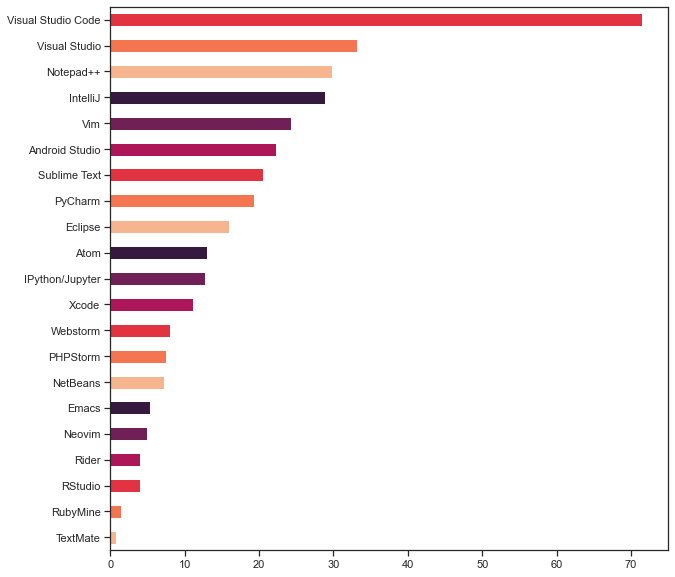

In [15]:

plt.figure(figsize=(10,10))
data['NEWCollabToolsHaveWorkedWith'].str.split(';', expand=True).stack().value_counts().div(data['NEWCollabToolsHaveWorkedWith'].dropna().count()).sort_values(ascending=True).mul(100).plot.barh(color=palette)
display(pd.DataFrame(data['NEWCollabToolsHaveWorkedWith'].str.split(';', expand=True).stack().value_counts().div(data['NEWCollabToolsHaveWorkedWith'].dropna().count()), columns=['Percentage']))


In [16]:
#There is no revelant information per tool used. Code kept as a backup. 



# aux = df_explode(data,'NEWStuck')
# aux = df_explode(aux.reset_index(drop=True),'NEWCollabToolsHaveWorkedWith')

# filtr = ((aux['NEWStuck'] != 'Other (please specify):') & 
#          (aux['Gender'] != 'Or, in your own words:') &
#          (aux['MainBranch'] != 'None of these') &
#          (aux['Country'].isin(select_top_n(aux['Country']))) &
#          (aux['NEWCollabToolsHaveWorkedWith'].isin(select_top_n(aux['NEWCollabToolsHaveWorkedWith'], 5))) )

# aux = aux.loc[filtr]


# for var in ['NEWStuck',
#             'NEWSOSites',
#             'SOVisitFreq',
#             'SOAccount',
#             'SOPartFreq',
#             'SOComm',
#             'NEWOtherComms']:

#         plt.figure(figsize=(10,len(data[var].str.split(';', expand=True).stack().value_counts(normalize=True).index)))

#         aux_2 = (aux.groupby(['NEWCollabToolsHaveWorkedWith'])[var]
#                         .value_counts(normalize=True)
#                         .rename('Percentage')
#                         .mul(100)
#                         .reset_index()
#                         .sort_values(var))

#         ax = sns.barplot( data=aux_2,
#                         x='Percentage',
#                         hue='NEWCollabToolsHaveWorkedWith',
#                         y=var,
#                         orient='h',
#                         palette=palette)
#         # for idx, p in enumerate(ax.patches):
#         #     per = val[idx]
#         #     ax.annotate('{:.2f} %'.format(per), (p.get_width()+0.1, p.get_y()+p.get_height()))
#         labelsy = [textwrap.fill(label.get_text(), 30) for label in ax.get_yticklabels()]
#         ax.set_yticklabels(labelsy)
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#         plt.title(textwrap.fill(data_schema.loc[data_schema['qname'] == var, 'question'].values[0], 60), fontsize=20)